In [1]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
tf.executing_eagerly()

True

### TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later.

Basically if you experimenting use the default eager execution method, since it is easy to develop and debug. But if you need fast execution times use graph based execution.

### Tensorflow Gradient Tape is useful when computing backpropagation. (interesting use case)

In [3]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w
  print(loss)

grad = tape.gradient(loss, w)
print(grad)  # W**2 derivative is 2*W and derivative at 1 is therefore 2.

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


## Lets create a neural network to classify MNIST dataset

In [4]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [5]:
# Build the model
mnist_model = tf.keras.Sequential()

mnist_model.add(tf.keras.layers.Conv2D(16,[3,3], activation='relu', input_shape=(None, None, 1)))
mnist_model.add(tf.keras.layers.Conv2D(16,[3,3], activation='relu'))
mnist_model.add(tf.keras.layers.GlobalAveragePooling2D())
mnist_model.add(tf.keras.layers.Dense(10))


### This below code is possible because of the EAGER EXECUTION provided by the tensorflow. This model is not trained, but we can perform the forward prapagation

In [6]:
for images,labels in dataset.take(1):
  print("Logits (Last layer values): ", mnist_model(images[0:1]).numpy())

Logits (Last layer values):  [[ 0.00631617 -0.00770625 -0.03640431 -0.04774543  0.00959853 -0.01174832
   0.02219779  0.03650862 -0.03261926 -0.02151665]]


In [7]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [8]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)  #Get the last layer output
        
        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))

        loss_value = loss_object(labels, logits) # Calculate the output error

    loss_history.append(loss_value.numpy().mean())

    grads = tape.gradient(loss_value, mnist_model.trainable_variables)  # Calculate the gradient of loss (error function) at trainable_variable values
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [9]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('Epoch {} finished'.format(epoch+1))

In [10]:
train(epochs = 3)

Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


Text(0, 0.5, 'Loss [entropy]')

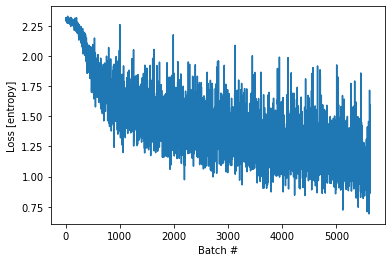

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

## Implementing  a Linear Model from Scratch

In [12]:
class Linear(tf.keras.Model):
    '''
    A class which defines a linear model in the for Wx+B.
    '''
    def __init__(self):
        super(Linear, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='biase')

    def call(self, inputs):
        '''
        Inputs can be a vector. Then the weights and biases with broadcast to form Wx+B
        '''
        return inputs * self.W + self.B

In [13]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

In [14]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
    grads = grad(model, training_inputs, training_outputs) # Calculating the gradient
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))   # Calculating the delta values and updating the variable (Backpropagation)
    if i % 20 == 0:
        print(f"Loss at step {i}: {loss(model, training_inputs, training_outputs)} with W={model.W.numpy()} and B={model.B.numpy()}")

Initial loss: 68.415
Loss at step 0: 65.75505065917969 with W=4.961260795593262 and B=9.840719223022461
Loss at step 20: 29.94557762145996 with W=4.325680255889893 and B=7.245708465576172
Loss at step 40: 13.93973445892334 with W=3.8950536251068115 and B=5.51219367980957
Loss at step 60: 6.7852654457092285 with W=3.6033313274383545 and B=4.3541646003723145
Loss at step 80: 3.5871479511260986 with W=3.4057350158691406 and B=3.580568313598633
Loss at step 100: 2.15749454498291 with W=3.271911859512329 and B=3.063779354095459
Loss at step 120: 1.5183677673339844 with W=3.1812920570373535 and B=2.7185425758361816
Loss at step 140: 1.2326343059539795 with W=3.1199355125427246 and B=2.4879086017608643
Loss at step 160: 1.1048856973648071 with W=3.078397274017334 and B=2.3338329792022705
Loss at step 180: 1.0477683544158936 with W=3.050279378890991 and B=2.2309012413024902
Loss at step 200: 1.022229790687561 with W=3.0312488079071045 and B=2.1621365547180176
Loss at step 220: 1.01080989837646